# 1. Przeprowadzić analizę podobieństwa wybranych rozdziałów
Wybrać po kilka rozdziałów z „Anna Karenina” i „Jane Eyre” i przeanalizować ich podobieństwo za pomocą metod opartych na wektorach tekstu (np. TF-IDF lub Word2Vec). Określić, które rozdziały wykazują największe podobieństwo pod względem stylu lub treści.

In [3]:
!pip install Cython
!pip install --upgrade --force-reinstall gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.0.5
    Uninstalling smart-open-7.0.5:
      Successfully uninst

In [9]:
# 1. Import bibliotek
import pandas as pd
import re
import nltk
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# 2. Wczytanie plików i podział na rozdziały
with open('anna_karenina.txt', 'r', encoding='utf-8') as f:
    anna_karenina_text = f.read()
with open('jane_eyre.txt', 'r', encoding='utf-8') as f:
    jane_eyre_text = f.read()

In [32]:
# Tutaj warto zauważyć, że oba pliki .txt maja inne oznaczenie chapterow, alternatywa jest np szukanie wielu znakow nowej linii ale obawiam się, że może to też wyłapywać akapity itp
def split_into_chapters(text):
    # Wzorzec dopasowuje "CHAPTER IV", "CHAPTER V" (rzymskie liczby) lub "Chapter 1", "Chapter 2" (liczby arabskie)
    chapter_identifier = r"(?:CHAPTER\s+[IVXLCDM]+|Chapter\s+\d+)"
    chapters = re.split(chapter_identifier, text, flags=re.IGNORECASE)
    return [chapter.strip() for chapter in chapters if chapter.strip()]

In [35]:
anna_karenina_chapters = split_into_chapters(anna_karenina_text)
jane_eyre_chapters = split_into_chapters(jane_eyre_text)

In [36]:
selected_anna_chapters = anna_karenina_chapters[:5]  # Pierwsze 5 rozdziałów
selected_jane_chapters = jane_eyre_chapters[:5]  # Pierwsze 5 rozdziałów

In [37]:
# 3. Przetworzenie tekstu (tokenizacja i usuwanie stopwords np "the", "is", "and", "in", "to" itp)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)  # Usuwa znaki specjalne
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [39]:
preprocessed_anna = [preprocess_text(chapter) for chapter in selected_anna_chapters]
preprocessed_jane = [preprocess_text(chapter) for chapter in selected_jane_chapters]


In [40]:
# 4. Stworzenie reprezentacji TF-IDF
# Tworzenie korpusu i słownika aby móc przekształcić słowa w wektory liczbowe, co pozwala na porównywanie ich podobieństwa w sposób ilościowy.
dictionary = Dictionary(preprocessed_anna + preprocessed_jane)

corpus_anna = [dictionary.doc2bow(text) for text in preprocessed_anna]
corpus_jane = [dictionary.doc2bow(text) for text in preprocessed_jane]

tfidf = TfidfModel(corpus_anna + corpus_jane)

# Przekształcenie korpusów do reprezentacji TF-IDF
tfidf_corpus_anna = [tfidf[doc] for doc in corpus_anna]
tfidf_corpus_jane = [tfidf[doc] for doc in corpus_jane]

In [41]:
# 5. Obliczenie podobieństwa z TF-IDF
index = MatrixSimilarity(tfidf_corpus_jane, num_features=len(dictionary))

In [42]:
similarity_matrix = np.zeros((len(tfidf_corpus_anna), len(tfidf_corpus_jane)))
for i, doc in enumerate(tfidf_corpus_anna):
    sims = index[doc]  # Podobieństwa do każdego rozdziału z "Jane Eyre"
    similarity_matrix[i] = sims

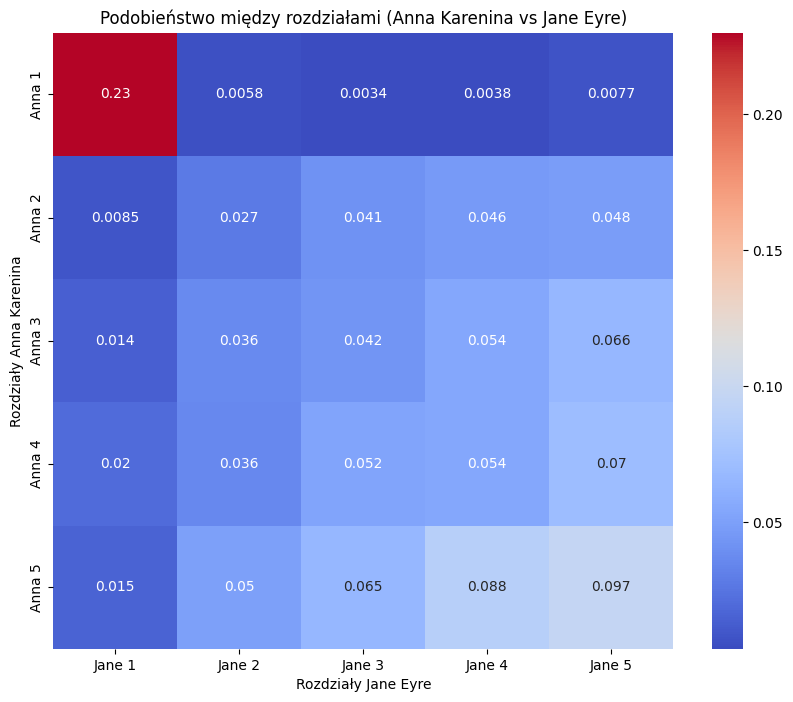

In [44]:
# Wizualizacja macierzy podobieństwa między książkami
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", cbar=True,
            xticklabels=[f'Jane {i+1}' for i in range(len(selected_jane_chapters))],
            yticklabels=[f'Anna {i+1}' for i in range(len(selected_anna_chapters))])
plt.title("Podobieństwo między rozdziałami (Anna Karenina vs Jane Eyre)")
plt.xlabel("Rozdziały Jane Eyre")
plt.ylabel("Rozdziały Anna Karenina")
plt.show()

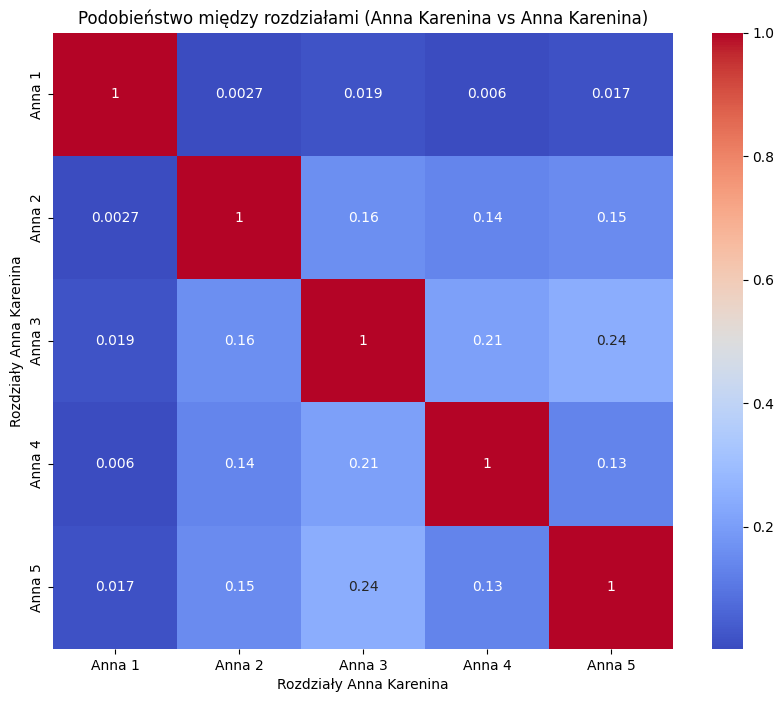

In [46]:
# 7. Porównanie rozdziałów Anna Karenina ze sobą
index_anna = MatrixSimilarity(tfidf_corpus_anna, num_features=len(dictionary))
similarity_matrix_anna = np.zeros((len(tfidf_corpus_anna), len(tfidf_corpus_anna)))

for i, doc in enumerate(tfidf_corpus_anna):
    sims = index_anna[doc]
    similarity_matrix_anna[i, :] = sims

# Wizualizacja macierzy podobieństwa rozdziałów Anna Karenina
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_anna, annot=True, cmap="coolwarm", cbar=True,
            xticklabels=[f'Anna {i+1}' for i in range(len(selected_anna_chapters))],
            yticklabels=[f'Anna {i+1}' for i in range(len(selected_anna_chapters))])
plt.title("Podobieństwo między rozdziałami (Anna Karenina vs Anna Karenina)")
plt.xlabel("Rozdziały Anna Karenina")
plt.ylabel("Rozdziały Anna Karenina")
plt.show()

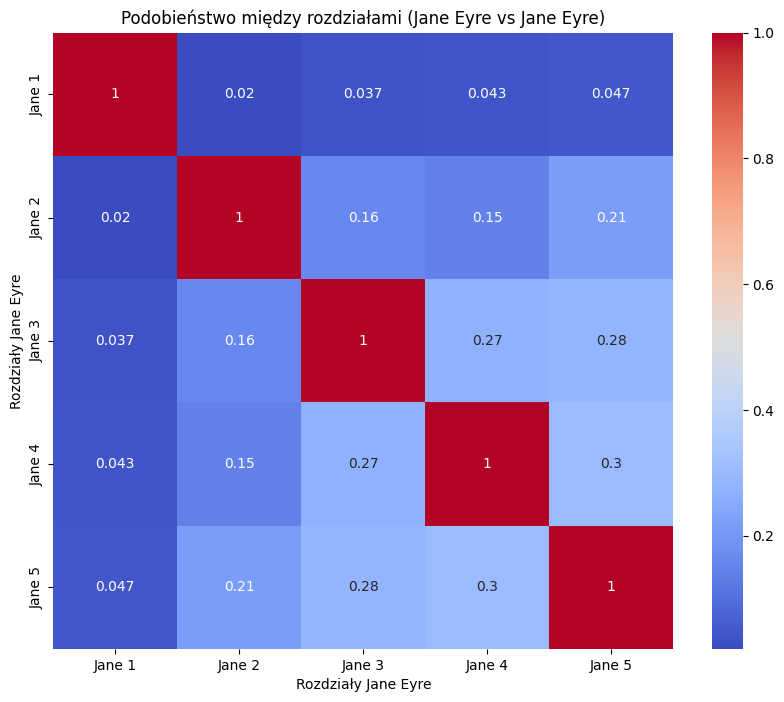

In [47]:
# 8. Porównanie rozdziałów Jane Eyre ze sobą
index_jane = MatrixSimilarity(tfidf_corpus_jane, num_features=len(dictionary))
similarity_matrix_jane = np.zeros((len(tfidf_corpus_jane), len(tfidf_corpus_jane)))

for i, doc in enumerate(tfidf_corpus_jane):
    sims = index_jane[doc]
    similarity_matrix_jane[i, :] = sims

# Wizualizacja macierzy podobieństwa rozdziałów Jane Eyre
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_jane, annot=True, cmap="coolwarm", cbar=True,
            xticklabels=[f'Jane {i+1}' for i in range(len(selected_jane_chapters))],
            yticklabels=[f'Jane {i+1}' for i in range(len(selected_jane_chapters))])
plt.title("Podobieństwo między rozdziałami (Jane Eyre vs Jane Eyre)")
plt.xlabel("Rozdziały Jane Eyre")
plt.ylabel("Rozdziały Jane Eyre")
plt.show()

# 2. Zbudować osadzenia słów i porównać użycie wybranych terminów
Wygenerować osadzenia słów (np. Word2Vec) dla obu książek i porównać, jak wybrane słowa (np. „miłość”, „małżeństwo”, „rodzina”) są reprezentowane w każdej z nich. Wykorzystać podobieństwo cosinusowe, aby zobaczyć, jak bliskie są te słowa względem innych wyrazów.


Początkowo źle przeczytałem polecenie i zrobiłem dla 5 rozdziałów jednak zostawiam ten fragment kodu w celu oceny polepszenia wyników przy trenowaniu modelu na całym pliku .txt

In [48]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [49]:
# 1. Trenowanie modelu Word2Vec dla każdej książki
# Używamy wcześniej przetworzonych danych (preprocessed_anna i preprocessed_jane)

# Model Word2Vec dla "Anna Karenina"
model_anna = Word2Vec(sentences=preprocessed_anna, vector_size=100, window=5, min_count=2, sg=1)

# Model Word2Vec dla "Jane Eyre"
model_jane = Word2Vec(sentences=preprocessed_jane, vector_size=100, window=5, min_count=2, sg=1)


In [50]:
# 2. Wybór słów do analizy
target_words = ["love", "marriage", "family"]

In [51]:
# 3. Funkcja do obliczania podobieństwa cosinusowego między słowami
def get_word_similarity(model, word, top_n=5):
    # Sprawdza podobieństwo względem najbliższych słów
    if word in model.wv:
        similar_words = model.wv.most_similar(word, topn=top_n)
        return similar_words
    else:
        return f"'{word}' nie występuje w modelu."


In [52]:
# 4. Analiza podobieństwa słów w obu książkach
for word in target_words:
    print(f"\nPodobne słowa do '{word}' w 'Anna Karenina':")
    print(get_word_similarity(model_anna, word))

    print(f"\nPodobne słowa do '{word}' w 'Jane Eyre':")
    print(get_word_similarity(model_jane, word))


Podobne słowa do 'love' w 'Anna Karenina':
[('arkadyevitch', 0.8806336522102356), ('said', 0.8781701326370239), ('children', 0.8714256882667542), ('face', 0.8652745485305786), ('room', 0.8642904162406921)]

Podobne słowa do 'love' w 'Jane Eyre':
[('head', 0.992226779460907), ('would', 0.9922125339508057), ('hand', 0.9919297099113464), ('seemed', 0.9919283390045166), ('bessie', 0.9917937517166138)]

Podobne słowa do 'marriage' w 'Anna Karenina':
'marriage' nie występuje w modelu.

Podobne słowa do 'marriage' w 'Jane Eyre':
'marriage' nie występuje w modelu.

Podobne słowa do 'family' w 'Anna Karenina':
[('said', 0.7971847653388977), ('everything', 0.7889183759689331), ('would', 0.7886133790016174), ('arkadyevitch', 0.7835462689399719), ('children', 0.7793702483177185)]

Podobne słowa do 'family' w 'Jane Eyre':
[('cold', 0.9107189178466797), ('something', 0.9096060395240784), ('low', 0.9079965949058533), ('disposed', 0.9079830646514893), ('afraid', 0.9078371524810791)]


Aby poprawić wyniki możemy spróbować wytrenować model na całej książce oraz zmienić parametry trenowania modelu

In [53]:
with open('anna_karenina.txt', 'r', encoding='utf-8') as f:
    anna_karenina_text = f.read()
with open('jane_eyre.txt', 'r', encoding='utf-8') as f:
    jane_eyre_text = f.read()
stop_words = set(stopwords.words("english"))

In [54]:
def preprocess_text_sentences(text):
    sentences = sent_tokenize(text)
    processed_sentences = []
    for sentence in sentences:
        # Usunięcie znaków specjalnych
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        tokens = word_tokenize(sentence.lower())
        # Usunięcie stop-words
        tokens = [word for word in tokens if word not in stop_words]
        if tokens:  # Dodajemy tylko, jeśli lista nie jest pusta
            processed_sentences.append(tokens)
    return processed_sentences

In [55]:
# Przetworzone teksty jako lista zdań z tokenami
sentences_anna = preprocess_text_sentences(anna_karenina_text)
sentences_jane = preprocess_text_sentences(jane_eyre_text)

In [56]:
# 4. Trenowanie modeli Word2Vec na pełnych tekstach
# Ustawienie parametrów modelu
model_anna = Word2Vec(sentences=sentences_anna, vector_size=200, window=5, min_count=2, workers=4, epochs=10, sg=1)
model_jane = Word2Vec(sentences=sentences_jane, vector_size=200, window=5, min_count=2, workers=4, epochs=10, sg=1)


In [57]:
# 5. Wybór słów do analizy
target_words = ["love", "marriage", "family"]

In [59]:
# 6. Funkcja do uzyskania najbardziej podobnych słów
def get_similar_words(model, word, top_n=5):
    if word in model.wv.key_to_index:
        similar_words = model.wv.most_similar(word, topn=top_n)
        return similar_words
    else:
        return f"'{word}' nie znaleziono w słowniku modelu."

In [60]:
# 7. Analiza wybranych słów w obu modelach
for word in target_words:
    print(f"\nPodobne słowa do '{word}' w 'Anna Karenina':")
    result_anna = get_similar_words(model_anna, word)
    print(result_anna)

    print(f"\nPodobne słowa do '{word}' w 'Jane Eyre':")
    result_jane = get_similar_words(model_jane, word)
    print(result_jane)


Podobne słowa do 'love' w 'Anna Karenina':
[('loved', 0.7914674282073975), ('loving', 0.7617527842521667), ('child', 0.7582349181175232), ('fall', 0.7543761730194092), ('loves', 0.7522740364074707)]

Podobne słowa do 'love' w 'Jane Eyre':
[('loved', 0.9305915832519531), ('affection', 0.9028094410896301), ('ever', 0.902463436126709), ('nature', 0.9009971022605896), ('man', 0.8897837996482849)]

Podobne słowa do 'marriage' w 'Anna Karenina':
[('misfortune', 0.9277068376541138), ('sorrow', 0.9273471832275391), ('abandoned', 0.9244214296340942), ('relation', 0.9237494468688965), ('occupation', 0.9217766523361206)]

Podobne słowa do 'marriage' w 'Jane Eyre':
[('fond', 0.9894013404846191), ('obedience', 0.9873762130737305), ('concerning', 0.9873620867729187), ('matrimony', 0.987131655216217), ('eyres', 0.9861834049224854)]

Podobne słowa do 'family' w 'Anna Karenina':
[('regiment', 0.8412438035011292), ('girls', 0.8393025994300842), ('household', 0.8389753103256226), ('youth', 0.83335673809

In [61]:
def compare_word_vectors(word, model1, model2):
    if word in model1.wv.key_to_index and word in model2.wv.key_to_index:
        vector1 = model1.wv[word].reshape(1, -1)
        vector2 = model2.wv[word].reshape(1, -1)
        similarity = cosine_similarity(vector1, vector2)[0][0]
        return similarity
    else:
        return f"'{word}' nie znaleziono w obu słownikach modeli."

print("\nPodobieństwo cosinusowe reprezentacji słów między 'Anna Karenina' a 'Jane Eyre':")
for word in target_words:
    similarity = compare_word_vectors(word, model_anna, model_jane)
    print(f"Podobieństwo cosinusowe dla '{word}': {similarity}")


Podobieństwo cosinusowe reprezentacji słów między 'Anna Karenina' a 'Jane Eyre':
Podobieństwo cosinusowe dla 'love': 0.24639593064785004
Podobieństwo cosinusowe dla 'marriage': 0.6771166324615479
Podobieństwo cosinusowe dla 'family': 0.5240219235420227


# 3. Stworzyć model klasyfikacji toksyczności przy użyciu wektorów
Korzystając z Gensim, wygenerować wektory tekstowe (np. TF-IDF) dla komentarzy, a następnie użyć modelu uczenia maszynowego do klasyfikacji toksycznych i nietoksycznych treści.

In [88]:
import pandas as pd
import numpy as np
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [89]:
csv_path = 'sample.csv'
df = pd.read_csv(csv_path)

In [90]:
# 1. Przygotowanie danych
# Przekształcenie etykiety `target` w klasę binarną (1 dla toksyczne, 0 dla nietoksyczne)
df['toxic_label'] = df['target'].apply(lambda x: 1 if x > 0.3 else 0)

In [91]:
# Rozdzielenie danych na toksyczne i nietoksyczne
toxic_comments = df[df['toxic_label'] == 1]
non_toxic_comments = df[df['toxic_label'] == 0]

In [92]:

print(f"Liczba toksycznych komentarzy: {len(toxic_comments)}")
print(f"Liczba nietoksycznych komentarzy: {len(non_toxic_comments)}")

Liczba toksycznych komentarzy: 1094
Liczba nietoksycznych komentarzy: 8906


In [95]:
# Oversampling toksycznych komentarzy
toxic_comments_oversampled = toxic_comments.sample(n=len(toxic_comments) + 300, replace=True)

# Połączenie z nietoksycznymi komentarzami
df_oversampled = pd.concat([toxic_comments_oversampled, non_toxic_comments])

print(f"Liczba toksycznych komentarzy po oversamplingu: {len(df_oversampled[df_oversampled['toxic_label'] == 1])}")
print(f"Liczba nietoksycznych komentarzy: {len(df_oversampled[df_oversampled['toxic_label'] == 0])}")


Liczba toksycznych komentarzy po oversamplingu: 1394
Liczba nietoksycznych komentarzy: 8906


In [78]:
# 2. Przetwarzanie tekstu
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)  # Usuwa znaki specjalne
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [96]:
# Przekształcenie tekstu na listę tokenów
processed_comments = [preprocess_text(comment) for comment in df_oversampled['comment_text']]

In [97]:
# Tworzenie słownika i reprezentacji TF-IDF
dictionary = Dictionary(processed_comments)
corpus = [dictionary.doc2bow(text) for text in processed_comments]
tfidf = TfidfModel(corpus)
tfidf_corpus = [tfidf[doc] for doc in corpus]

In [98]:
# Konwersja do macierzy rzadkiej (sparse matrix) dla kompatybilności ze Scikit-Learn
num_docs = len(tfidf_corpus)
num_terms = len(dictionary)
data = []
rows = []
cols = []

for row_idx, doc in enumerate(tfidf_corpus):
    for col_idx, value in doc:
        rows.append(row_idx)
        cols.append(col_idx)
        data.append(value)

tfidf_matrix = csr_matrix((data, (rows, cols)), shape=(num_docs, num_terms))


In [99]:
# 3. Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df_oversampled['toxic_label'], test_size=0.2, random_state=7)


In [100]:
# 4. Trenowanie modelu klasyfikacyjnego
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [101]:
# 5. Ewaluacja modelu
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Dokładność modelu (accuracy):", accuracy)
print("F1-score modelu:", f1)

Dokładność modelu (accuracy): 0.8864077669902912
F1-score modelu: 0.19863013698630136


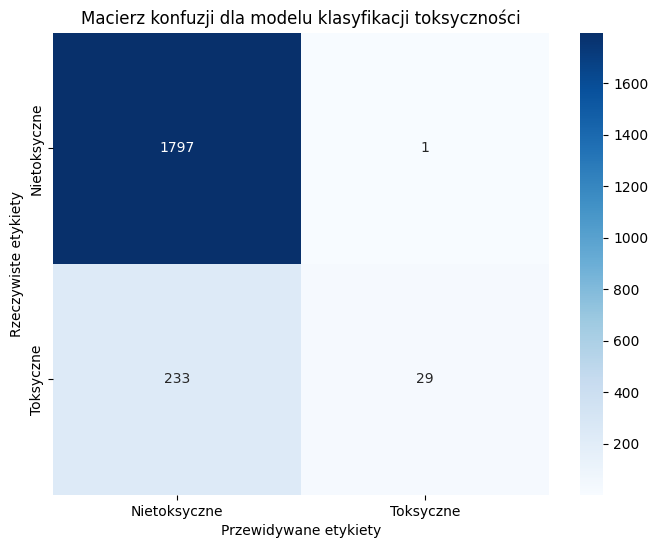

In [102]:
# Wyświetlenie macierzy konfuzji
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Nietoksyczne", "Toksyczne"], yticklabels=["Nietoksyczne", "Toksyczne"])
plt.xlabel("Przewidywane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.title("Macierz konfuzji dla modelu klasyfikacji toksyczności")
plt.show()

# 4. Stworzyć słownik toksycznych słów i porównać go z nietoksycznymi
Na podstawie komentarzy stworzyć słownik wyrazów lub fraz, które występują częściej w toksycznych komentarzach. Użyć podobieństwa słów (Word2Vec) do poszukiwania innych słów o podobnej toksycznej wymowie.

In [103]:
from collections import Counter

In [104]:
# 1. Przetwarzanie tekstu toksycznych i nietoksycznych komentarzy na tokeny
toxic_comments_tokens = [preprocess_text(comment) for comment in toxic_comments['comment_text']]
non_toxic_comments_tokens = [preprocess_text(comment) for comment in non_toxic_comments['comment_text']]


In [105]:
# 2. Tworzenie słownika toksycznych słów
# Zliczamy wystąpienia słów w toksycznych i nietoksycznych komentarzach
toxic_words = Counter([word for comment in toxic_comments_tokens for word in comment])
non_toxic_words = Counter([word for comment in non_toxic_comments_tokens for word in comment])


In [106]:
# Wybieramy toksyczne słowa - te, które są częściej w toksycznych komentarzach niż w nietoksycznych
toxic_word_dict = {word: count for word, count in toxic_words.items() if count > non_toxic_words[word]}

# Wyświetlenie najczęstszych toksycznych słów
print("Najczęstsze toksyczne słowa:", dict(Counter(toxic_word_dict).most_common(10)))

Najczęstsze toksyczne słowa: {'stupid': 81, 'ignorant': 44, 'idiot': 32, 'loser': 26, 'pathetic': 25, 'liar': 24, 'gay': 23, 'fool': 22, 'clown': 22, 'dumb': 22}


In [107]:
# 3. Model Word2Vec dla toksycznych komentarzy
model_toxic = Word2Vec(sentences=toxic_comments_tokens, vector_size=100, window=5, min_count=2, sg=1)

In [108]:
# 4. Znajdowanie słów o podobnej toksycznej wymowie
# Wybieramy najczęstsze toksyczne słowa i wyszukujemy ich podobne wyrazy
similar_toxic_words = {}
for toxic_word in list(toxic_word_dict.keys())[:10]:  # Sprawdzamy tylko 10 najczęstszych toksycznych słów
    if toxic_word in model_toxic.wv:
        similar_toxic_words[toxic_word] = model_toxic.wv.most_similar(toxic_word, topn=5)


# Wyświetlenie podobnych słów
print("\nSłowa o podobnej wymowie toksycznej:")
for word, similar_words in similar_toxic_words.items():
    print(f"{word}: {[sim[0] for sim in similar_words]}")


Słowa o podobnej wymowie toksycznej:
believable: ['whites', 'aliens', 'canada', 'maybe', 'little']
ignorant: ['canadians', 'make', 'social', 'conservative', 'canadian']
condescension: ['watch', 'attorney', 'solution', 'ask', 'never']


Wyniki nie są najlepsze z uwagi na brak odpowiednich danych treningowych
